# LSTM Model

## Website link

In [ ]:
# #Yearly Data
# yearly_data = data.resample('Y').mean()
# yearly_data

In [ ]:
# #Monthly Data
# monthly_data = data.resample('M').mean()
# monthly_data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import seaborn as sns

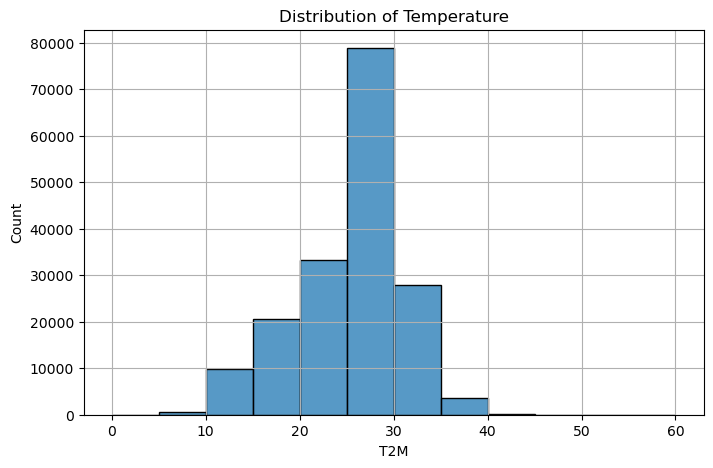

                      Date    T2M  T2MDEW  T2MWET      PS     PSC  WS2M  \
0      2004-01-01 06:00:00  11.97   11.30   11.63  101.33  101.51  0.43   
1      2004-01-01 07:00:00  12.95   11.55   12.25  101.41  101.60  0.33   
2      2004-01-01 08:00:00  15.06   11.97   13.51  101.49  101.67  0.07   
3      2004-01-01 09:00:00  19.23   11.73   15.48  101.56  101.74  0.49   
4      2004-01-01 10:00:00  21.79   11.19   16.48  101.50  101.68  0.60   
...                    ...    ...     ...     ...     ...     ...   ...   
174565 2023-11-30 19:00:00  21.91   16.82   19.37  101.19  101.37  1.06   
174566 2023-11-30 20:00:00  21.50   16.54   19.02  101.28  101.46  1.02   
174567 2023-11-30 21:00:00  21.12   16.33   18.73  101.30  101.48  0.96   
174568 2023-11-30 22:00:00  20.69   16.20   18.44  101.31  101.48  0.91   
174569 2023-11-30 23:00:00  20.08   16.11   18.10  101.26  101.44  0.91   

         QV2M   RH2M  PRECTOTCORR  
0        8.24  95.50          0.0  
1        8.36  91.00       

In [19]:
# Load the data
data = pd.read_csv('/Users/darshmac/Documents/Cdac Project/Agartala_combined_data.csv')

# Drop the last 6 rows from the main DataFrame
data = data.iloc[:-6]

# Create a new DataFrame with the last 744 rows and drop them from the main DataFrame
last_month_rows = data.iloc[-744:]
data = data.iloc[:-744]

plt.figure(figsize=(8,5))
sns.histplot(data.T2M,bins=[i for i in range(0,61,5)],kde=False)
plt.title("Distribution of Temperature")
plt.grid()
plt.show()

# Convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d%H')

# Print the resulting DataFrame
print(data)

data.index = data['Date']

# Rename columns
old_columns = ['T2M','T2MDEW','T2MWET','PS','PSC','WS2M','QV2M','RH2M','PRECTOTCORR']
new_columns = ['Temp2m','Dew2m','Wet_bulb_temp2m','Surface_pressure','Corrected_atm_pressure','Wind_speed2m','Specific_humidity2m','Relative_humidity2m','Precipitation_corrected']
columns_mapping = dict(zip(old_columns, new_columns))
data = data.rename(columns=columns_mapping)

# Dropping unnecessary columns
not_req_col = ['Corrected_atm_pressure','Precipitation_corrected']
data = data.drop(columns=not_req_col)

# Extract and set aside the datetime column
datetime_column = data['Date']
data = data.drop(columns=['Date'])

# Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define sequence (will be taking 12 hours)
sequence_length = 12  # number of steps in each sequence

# Features
num_features = len(data.columns)

# Create sequence and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0]  # 'Temp2m' column index
    sequences.append(seq)
    labels.append(label)

# Converting to numpy array (because pandas need in numpy array)
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape : ", train_x.shape)
print("Train Y shape : ", train_y.shape)
print("Test X shape: ", test_x.shape)
print("Test y shape: ", test_y.shape)

There are two sections of the data, one for the year 2004 and another for November 30, 2023.
The temperature distribution ranges from around -20 to 30 degrees Celsius.
The precipitation values range from 0 to around 180 mm.
There are also other variables, such as relative humidity (RH2M) and wind speed (WS2M).
The training dataset has 139646 samples, each with 12 timesteps and 7 features, and 1 target variable.
The testing dataset has 34912 samples, each with the same features and target variable.
The data appears to be cleaned, with no missing or null values, which is important for building accurate machine learning models.
The data has a time component, with 12 timesteps, which can be used for time series analysis or forecasting.

In [3]:
# Create LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           69632     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [5]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=50,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1528/1528 [==============================] - ETA: 0s - loss: 0.0061

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 81s 48ms/step - loss: 0.0061 - val_loss: 4.2688e-04
Epoch 2/50
1528/1528 [==============================] - ETA: 0s - loss: 0.0015

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 71s 47ms/step - loss: 0.0015 - val_loss: 2.4930e-04
Epoch 3/50
1527/1528 [============================>.] - ETA: 0s - loss: 7.1150e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 77s 50ms/step - loss: 7.1143e-04 - val_loss: 2.1954e-04
Epoch 4/50
1528/1528 [==============================] - ETA: 0s - loss: 5.3705e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 75s 49ms/step - loss: 5.3705e-04 - val_loss: 1.4492e-04
Epoch 5/50
1528/1528 [==============================] - 62s 41ms/step - loss: 4.8107e-04 - val_loss: 1.5935e-04
Epoch 6/50
1528/1528 [==============================] - 60s 39ms/step - loss: 4.5735e-04 - val_loss: 1.5868e-04
Epoch 7/50
1527/1528 [============================>.] - ETA: 0s - loss: 4.3631e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 72s 47ms/step - loss: 4.3629e-04 - val_loss: 1.2288e-04
Epoch 8/50
1527/1528 [============================>.] - ETA: 0s - loss: 4.1978e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 75s 49ms/step - loss: 4.1973e-04 - val_loss: 1.1451e-04
Epoch 9/50
1528/1528 [==============================] - 60s 39ms/step - loss: 4.0249e-04 - val_loss: 1.7623e-04
Epoch 10/50
1528/1528 [==============================] - 57s 37ms/step - loss: 3.8778e-04 - val_loss: 1.2268e-04
Epoch 11/50
1528/1528 [==============================] - 56s 37ms/step - loss: 3.8399e-04 - val_loss: 2.4648e-04
Epoch 12/50
1528/1528 [==============================] - ETA: 0s - loss: 3.6521e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 79s 51ms/step - loss: 3.6521e-04 - val_loss: 1.0048e-04
Epoch 13/50
1528/1528 [==============================] - 67s 44ms/step - loss: 3.6489e-04 - val_loss: 1.0108e-04
Epoch 14/50
1528/1528 [==============================] - 59s 39ms/step - loss: 3.6049e-04 - val_loss: 1.2324e-04
Epoch 15/50
1527/1528 [============================>.] - ETA: 0s - loss: 3.4741e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 76s 50ms/step - loss: 3.4744e-04 - val_loss: 9.3958e-05
Epoch 16/50
1528/1528 [==============================] - 69s 45ms/step - loss: 3.4693e-04 - val_loss: 1.1860e-04
Epoch 17/50
1528/1528 [==============================] - 64s 42ms/step - loss: 3.4087e-04 - val_loss: 9.5249e-05
Epoch 18/50
1528/1528 [==============================] - 71s 47ms/step - loss: 3.3496e-04 - val_loss: 1.1650e-04
Epoch 19/50
1528/1528 [==============================] - 61s 40ms/step - loss: 3.3457e-04 - val_loss: 1.2297e-04
Epoch 20/50
1527/1528 [============================>.] - ETA: 0s - loss: 3.2939e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 77s 50ms/step - loss: 3.2944e-04 - val_loss: 9.0538e-05
Epoch 21/50
1526/1528 [============================>.] - ETA: 0s - loss: 3.2002e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 75s 49ms/step - loss: 3.2010e-04 - val_loss: 8.7062e-05
Epoch 22/50
1528/1528 [==============================] - 58s 38ms/step - loss: 3.2418e-04 - val_loss: 1.3307e-04
Epoch 23/50
1528/1528 [==============================] - 55s 36ms/step - loss: 3.2224e-04 - val_loss: 9.1647e-05
Epoch 24/50
1528/1528 [==============================] - 55s 36ms/step - loss: 3.1043e-04 - val_loss: 1.0246e-04
Epoch 25/50
1528/1528 [==============================] - ETA: 0s - loss: 3.1425e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 69s 45ms/step - loss: 3.1425e-04 - val_loss: 7.8373e-05
Epoch 26/50
1528/1528 [==============================] - 55s 36ms/step - loss: 3.1243e-04 - val_loss: 8.8863e-05
Epoch 27/50
1528/1528 [==============================] - 62s 41ms/step - loss: 3.0879e-04 - val_loss: 9.5103e-05
Epoch 28/50
1528/1528 [==============================] - 59s 38ms/step - loss: 3.0586e-04 - val_loss: 7.9097e-05
Epoch 29/50
1528/1528 [==============================] - 56s 37ms/step - loss: 3.0233e-04 - val_loss: 8.4292e-05
Epoch 30/50
1528/1528 [==============================] - ETA: 0s - loss: 3.0184e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 70s 46ms/step - loss: 3.0184e-04 - val_loss: 7.4129e-05
Epoch 31/50
1528/1528 [==============================] - 56s 36ms/step - loss: 2.9970e-04 - val_loss: 8.0267e-05
Epoch 32/50
1528/1528 [==============================] - 55s 36ms/step - loss: 2.9441e-04 - val_loss: 9.2855e-05
Epoch 33/50
1528/1528 [==============================] - 56s 37ms/step - loss: 2.9825e-04 - val_loss: 8.2412e-05
Epoch 34/50
1528/1528 [==============================] - ETA: 0s - loss: 2.9847e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 70s 46ms/step - loss: 2.9847e-04 - val_loss: 7.0785e-05
Epoch 35/50
1528/1528 [==============================] - 57s 37ms/step - loss: 2.9238e-04 - val_loss: 7.5823e-05
Epoch 36/50
1528/1528 [==============================] - 55s 36ms/step - loss: 2.9368e-04 - val_loss: 8.3094e-05
Epoch 37/50
1528/1528 [==============================] - 55s 36ms/step - loss: 2.8927e-04 - val_loss: 8.1990e-05
Epoch 38/50
1528/1528 [==============================] - 55s 36ms/step - loss: 2.9019e-04 - val_loss: 7.2028e-05
Epoch 39/50
1528/1528 [==============================] - 58s 38ms/step - loss: 2.8865e-04 - val_loss: 7.1271e-05


In [6]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss: ", test_loss)

1091/1091 [==============================] - 11s 9ms/step - loss: 8.4767e-05
Test Loss:  8.47665942274034e-05


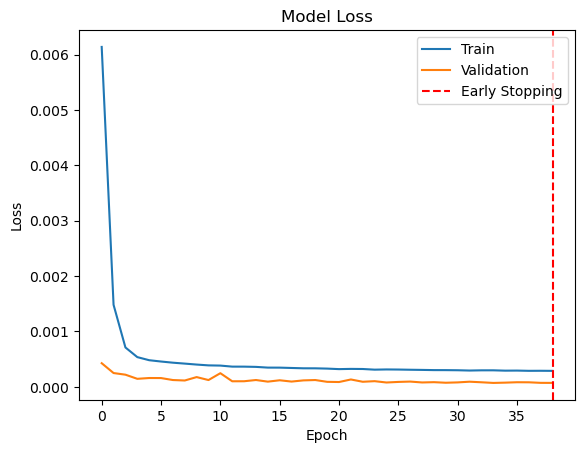

In [7]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')

# Add a vertical line at the epoch where early stopping occurred
if early_stopping.stopped_epoch is not None:
    plt.axvline(x=early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_predictions = best_model.predict(test_x)

mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("For 2004 till 2023-11-30")
print("Mean Absolute Error (MAE) :", mae)
print("Mean Squared Error (MSE) :", mse)
print("Root Mean Squared Error (MAE) :", rmse)

1091/1091 [==============================] - 10s 9ms/step
For 2004 till 2023-11-30
Mean Absolute Error (MAE) : 0.006142971656486923
Mean Squared Error (MSE) : 8.476660949697109e-05
Root Mean Squared Error (MAE) : 0.009206878379612229


In [13]:
test_y_copies = np.repeat(test_y.reshape(-1,1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,0]

#Predicted values
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, 7, axis=1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]

1091/1091 [==============================] - 10s 9ms/step


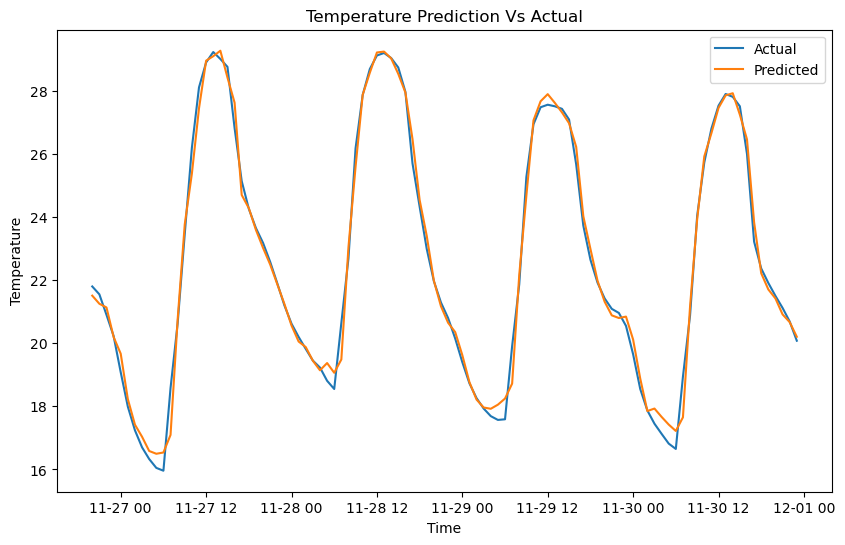

In [21]:
plt.figure(figsize=(10,6))
plt.plot(data.index[-100:], true_temp[-100:], label='Actual')
plt.plot(data.index[-100:], predicted_temp[-100:], label='Predicted')
plt.title('Temperature Prediction Vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [8]:
# Make predictions on the last month
# Rename columns for last_month_rows
last_month_rows = last_month_rows.rename(columns=columns_mapping)
d_col = ['Corrected_atm_pressure','Precipitation_corrected','Date']
last_month_rows = last_month_rows.drop(columns=d_col)

dec_month_data = scaler.transform(last_month_rows)
last_month_rows_scaled = scaler.transform(last_month_rows)

# Assuming 'last_month_rows_scaled' has shape (number_of_rows, number_of_features)
# Assuming 'sequence_length' is the sequence length you used during training
sequence_length = 12  # Replace with the actual sequence length

# Reshape the data
num_rows, num_features = last_month_rows_scaled.shape
num_sequences = num_rows - sequence_length + 1
last_month_rows_reshaped = np.zeros((num_sequences, sequence_length, num_features))

for i in range(num_sequences):
    last_month_rows_reshaped[i] = last_month_rows_scaled[i:i+sequence_length]

23/23 [==============================] - 2s 9ms/step


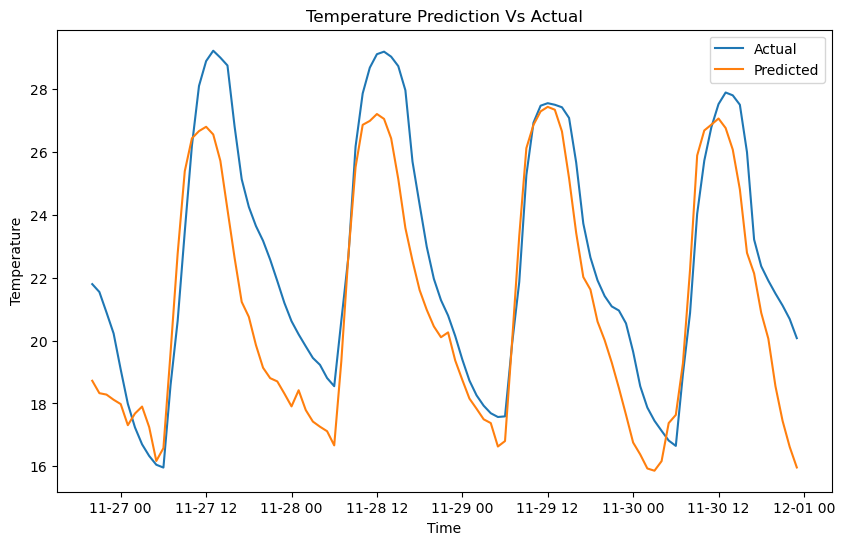

In [9]:
# Make predictions using the trained model
last_month_predictions = best_model.predict(last_month_rows_reshaped)

# Reshape predictions to match the scaler's expectations
last_month_predictions_reshaped = last_month_predictions.reshape(-1, 1)
predictions_copies = np.repeat(last_month_predictions_reshaped, num_features, axis=1)

# Inverse transform the predictions
predictions_original_scale = scaler.inverse_transform(predictions_copies)

# Extract true temperature for the last 100 time steps
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:, 0]

# Extract predicted temperature for the last 100 time steps
predicted_temp = predictions_original_scale[-100:, 0]

# Plot actual and predicted temperatures for the last 100 time steps
plt.figure(figsize=(10, 6))
plt.plot(datetime_column[-100:], true_temp[-100:], label='Actual')
plt.plot(datetime_column[-100:], predicted_temp, label='Predicted')
plt.title('Temperature Prediction Vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [10]:
# Calculate and print evaluation metrics
mae = mean_absolute_error(true_temp[-100:], predicted_temp)
mse = mean_squared_error(true_temp[-100:], predicted_temp)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1.7882482681274416
Mean Squared Error (MSE): 4.598340662676686
Root Mean Squared Error (RMSE): 2.144374189052994
